# Prerequisite
You need the acceptance_modelisation (Version 0.2.0) library to run this notebook: https://github.com/mdebony/acceptance_modelisation

For this you have 2 options:
>* From the cluster, it is already installed in the school environment __lst-school-2024-02__
>* Create a __custom environment__ containing all dependencies, __clone__ the git repository and follow the __installation instructions__

## Installation in custom environment

1. Make sure your custom environment meets the requirements

You can use the gammapy-1.1 environment as as a base: 
    
> curl -O https://gammapy.org/download/install/gammapy-1.1-environment.yml
> 
>conda env create -f gammapy-1.1-environment.yml -n ENVNAME

Or install lstchain v0.10.7.

Alternativelly, create a dedicated environment from scratch. Since package versions are not enforced in the package here is an exemple allowing to run the full notebook (except the call to acceptance_model[obs_id].plot_at_energy):

> conda create -n ENVNAME python=3.11.7 numpy=1.26.3 gammapy=1.1 astropy=5.3.4 scipy=1.11.4 regions=0.8 jupyter
    
2. Activate the custom environment and install the library

> conda activate ENVNAME
>
> git clone https://github.com/mdebony/acceptance_modelisation.git
> 
> cd acceptance_modelisation
> 
> python setup.py install





# Imports

In [1]:
from pathlib import Path
import sys

from acceptance_modelisation import RadialAcceptanceMapCreator, Grid3DAcceptanceMapCreator

import astropy.units as u
from astropy.coordinates import SkyCoord,EarthLocation
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.data import DataStore
from gammapy.makers import FoVBackgroundMaker, MapDatasetMaker, SafeMaskMaker, RingBackgroundMaker
from gammapy.estimators import ExcessMapEstimator
from gammapy.datasets import Datasets, MapDataset, MapDatasetOnOff
from astropy.visualization.wcsaxes import SphericalCircle

from regions import CircleSkyRegion, Regions

from scipy.stats import norm

import matplotlib.pyplot as plt
import numpy as np

# Data loading

In [24]:
# Path to the input DL3 data files
path_crab_school="/fefs/aswg/workspace/analysis-school-2024/DL3/Crab_Dec_2023"

PATH_DATA=path_crab_school

# Select 2D (offset, Energy) or 3D (x, y, energy) background acceptance
bkg_dim=2

# Path to the output fits file for the background acceptance
# acceptance_files_dir=f"./data/acceptance_fits_{bkg_dim}D_pointlike_school_crab_school"
acceptance_files_dir=f"./output/skymaps/"
Path(acceptance_files_dir).mkdir(parents=True, exist_ok=True)

In [3]:
# Load the information on available observations
data_store = DataStore.from_dir(f"{PATH_DATA}")
obs_table = data_store.obs_table
all_sources = np.unique(data_store.obs_table["OBJECT"])
all_obs_ids = obs_table["OBS_ID"].data
print("Available sources: ", all_sources.tolist())
print(f"{len(all_obs_ids)} available runs: ",all_obs_ids.tolist())

if len(all_sources) > 1:
    print("\nSource: run list")
    for source in all_sources:
        source_obs_ids = obs_table[obs_table["OBJECT"] == source]["OBS_ID"].data
        print(f"{source}: {source_obs_ids.tolist()}")

display(data_store.obs_table)

Available sources:  ['CrabNebula']
24 available runs:  [15996, 15997, 15998, 15999, 16001, 16002, 16003, 16066, 16069, 16070, 16071, 16072, 16073, 16074, 16075, 16173, 16174, 16177, 16178, 16179, 16180, 16181, 16182, 16183]


OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes10,bytes8,int64,bytes5,bytes5
15996,2023-12-12,01:03:32.716,2023-12-12,01:24:46.000,83.98636887364519,22.244853662510675,7.229101366271891,82.77089863372811,156.0220904139546,83.633212,22.01446,163991012.71643734,163992286.00045753,1273.28476023674,1273.2840201854706,1198.621328293564,0.941361560057238,CrabNebula,POINTING,1,LST-1,LST-1
15997,2023-12-12,01:25:09.142,2023-12-12,01:46:42.719,83.32132228119357,21.806782750559595,7.5625771574111695,82.43742284258883,200.8965127240037,83.633212,22.01446,163992309.14209914,163993602.7194965,1293.579003572464,1293.5773973464966,1223.54481424378,0.9458601375445401,CrabNebula,POINTING,1,LST-1,LST-1
15998,2023-12-12,01:47:04.572,2023-12-12,02:09:10.444,83.97620041854351,22.18816246156717,9.629253947262612,80.37074605273739,228.39475695982156,83.633212,22.01446,163993624.57151628,163994950.4439993,1325.861388206482,1325.8724830150604,1251.8481891560714,0.9441772724443468,CrabNebula,POINTING,1,LST-1,LST-1
15999,2023-12-12,02:09:32.429,2023-12-12,02:31:04.931,83.31633216983332,21.799122620483505,14.484203071949764,75.51579692805024,244.2163213927007,83.633212,22.01446,163994972.42873025,163996264.93061996,1292.5027601718903,1292.501889705658,1222.6267511963174,0.9459374392621954,CrabNebula,POINTING,1,LST-1,LST-1
16001,2023-12-12,02:54:01.899,2023-12-12,03:16:34.492,83.33396759920551,21.797345309423804,23.880664827507516,66.11933517249248,258.8017774907763,83.633212,22.01446,163997641.8993883,163998994.49152517,1352.5935142040253,1352.5921368598938,1285.200343281178,0.9501748528178424,CrabNebula,POINTING,1,LST-1,LST-1
16002,2023-12-12,03:16:54.924,2023-12-12,03:37:35.071,83.95423854841748,22.23538392550126,27.730765608457133,62.26923439154287,263.34256393711723,83.633212,22.01446,163999014.92443228,164000255.07099056,1240.1468114852905,1240.1465582847595,1179.4955422884796,0.9510934764859246,CrabNebula,POINTING,1,LST-1,LST-1
16003,2023-12-12,03:37:56.305,2023-12-12,03:58:06.866,83.3259156629939,21.795906058219103,33.03270880443528,56.96729119556472,266.15095703224813,83.633212,22.01446,164000276.305135,164001486.86554265,1210.5617802143097,1210.5604076385498,1155.355630619343,0.9543962559389629,CrabNebula,POINTING,1,LST-1,LST-1
16066,2023-12-14,00:41:21.251,2023-12-14,00:49:21.857,83.98537360658061,22.244971336841605,10.032552673696074,79.96744732630393,128.56473816053128,83.633212,22.01446,164162481.25060678,164162961.85746646,480.6089277267456,480.6068596839905,450.44426362284025,0.9372365714332803,CrabNebula,POINTING,1,LST-1,LST-1


Select source and run list, and load the data

In [4]:
source = None # fill with source name as in written in obs_table

all_runs = False # set to True if you want to load all the data from obs_table

if source is None:
    if len(all_sources)>1:
        raise ValueError("Error, multiple sources in PATH_DATA, but no source name provided")  
    else: source = all_sources[0]
else:
    obs_table = obs_table[obs_table["OBJECT"] == source]
    all_obs_ids = obs_table["OBS_ID"].data

if all_runs:
    obs_ids = all_obs_ids
else: 
    obs_ids = [15996, 16074, 16003, 16066, 16075, 16181, 16070, 16173, 16174, 16073, 15999, 16069, 16182, 16183, 16072, 16071, 16002, 16001, 16180, 16177, 16178, 15998, 16179, 15997]
    
obs_collection = data_store.get_observations(obs_ids, 
required_irf=['aeff', 'edisp']
)

## Acceptance model

A background model is created by stacking observations and measuring the number of events away from the source position.
It is here done by stacking runs in dynamic bins of zenith, and by interpolating the model for to create an IRF for each run.

__Create the model__
>* Add the observatory location to the observations info
>* Define the exclusion regions
>* Define the model binning
>* Create the model

In [6]:
# Your telescope position in an EarthLocation object
loc = EarthLocation.of_site('Roque de los Muchachos')

# Add telescope position to observations
for i in obs_collection:
    obs_collection[i].obs_info['GEOLON'] = loc.lon.value
    obs_collection[i].obs_info['GEOLAT'] = loc.lat.value
    obs_collection[i].obs_info['GEOALT'] = loc.height.value
    obs_collection[i]._location = loc
    obs_collection[i].obs_info['observatory_earth_location'] = loc 

# Declare the source coordinates
source_name = "Crab Nebula" # fill with the source name as accessible with astropy if different from name in the data store
source_pos = SkyCoord.from_name(source_name)

# The exclusion regions to apply during acceptance model calculation
# Here both the source position and a bright star position are removed but this can be any arbitrary region.
# Caveat : regions need to be defined such that they don't overlap in all wobbles (generally not an issue)
exclusion_radius=0.35*u.deg
source_region = CircleSkyRegion(center=source_pos, radius=exclusion_radius)

single_region=False # Set it to False to mask additional regions in the FoV
if single_region:
    exclude_regions=[source_region]
else:
    zeta_region = CircleSkyRegion(center=SkyCoord(ra=84.4125*u.deg, dec=21.1425*u.deg), radius=exclusion_radius)
    exclude_regions = [source_region, zeta_region]

# Define the energy and offset binning of the model
# The chosen binning can't be too fine since each bins must contain events
# The full dimension of the background IRF will be:
# - In 2D : nbin_energy X nbin_offset
# - In 3D : nbin_energy X (2 nbin_offset)(2 nbin_offset)
e_min, e_max = 0.2*u.TeV, 10.*u.TeV
size_fov = 2.5*u.deg
nbin_energy, nbin_offset = 6, 6

offset_axis_acceptance = MapAxis.from_bounds(np.finfo(np.float64).tiny*u.deg, size_fov, nbin=nbin_offset, name='offset')
energy_axis_acceptance = MapAxis.from_energy_bounds(e_min, e_max, nbin=nbin_energy, name='energy')

# Define the cos(zenith) binning of the model or stack all data
use_zenith_bin=True #if False, all data will use the same model and following parameters are not used
initial_cos_zenith_binning=0.01
min_observation_per_cos_zenith_bin=4

# Model normalisation
runwise_normalisation=False # Set it to True if the acceptance model is not binned in cos zenith

# Create the model
print(f"Model dimension: {bkg_dim}")
if bkg_dim==2:
    acceptance_model_creator = RadialAcceptanceMapCreator(energy_axis_acceptance,
                                                        offset_axis_acceptance,
                                                        exclude_regions=exclude_regions,
                                                        initial_cos_zenith_binning=initial_cos_zenith_binning,
                                                        min_observation_per_cos_zenith_bin=min_observation_per_cos_zenith_bin)
elif bkg_dim==3:
    acceptance_model_creator = Grid3DAcceptanceMapCreator(energy_axis_acceptance,
                                                      offset_axis_acceptance,
                                                      exclude_regions=exclude_regions,
                                                      initial_cos_zenith_binning=initial_cos_zenith_binning,
                                                      min_observation_per_cos_zenith_bin=min_observation_per_cos_zenith_bin)

acceptance_model = acceptance_model_creator.create_acceptance_map_per_observation(obs_collection,zenith_bin=use_zenith_bin,runwise_normalisation=runwise_normalisation)    

Model dimension: 2


__Check the model__

In 2D the model is characterised by a matrix of background rate versus (Energy, Offset) visible bottom-right of the figure produced by acceptance_model[obs_id].peek()

In 3D  the model is characterised by a matrix of background rate versus (Energy, x, y), which is better illustrated with acceptance_model[obs_id].plot_at_energy()

Observation 15996 pointing zenith at t=tmid: 7.1°


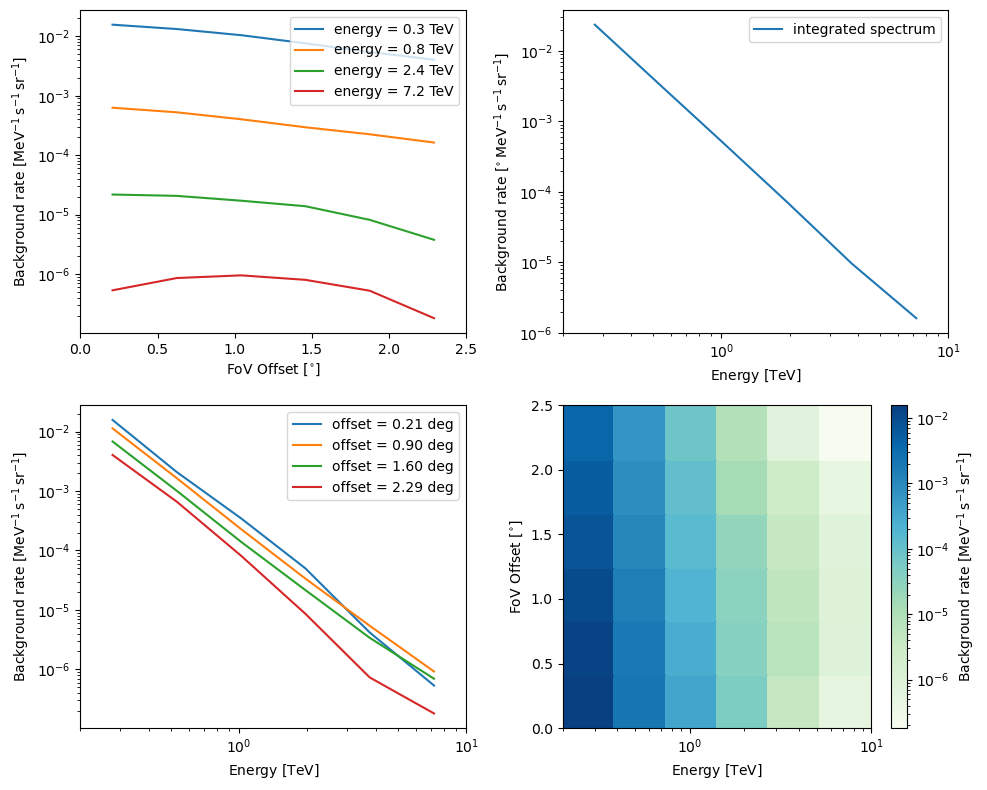

In [7]:
obs_id = obs_ids[0]
obs = obs_collection[str(obs_id)]
print(f"Observation {obs_id} pointing zenith at t=tmid: {obs.get_pointing_altaz(obs.tmid).zen.degree:.1f}°")
acceptance_model[obs_id].peek()

Observation 16180 pointing zenith at t=tmid: 21.0°


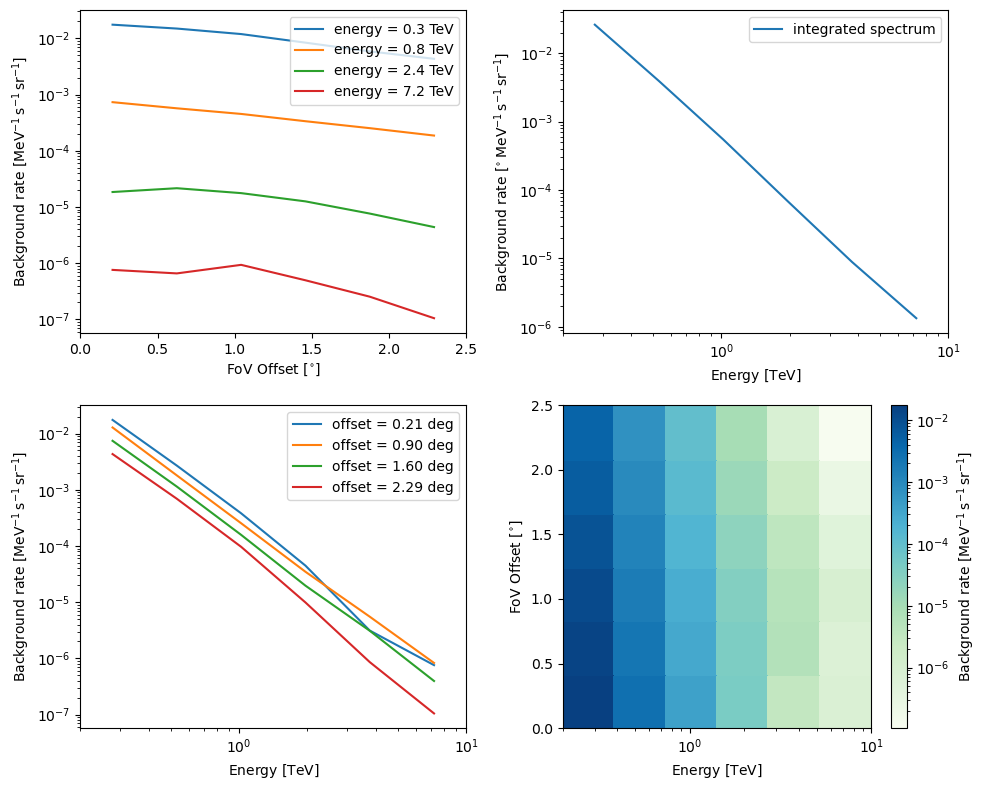

In [8]:
obs_id = 16180
obs = obs_collection[str(obs_id)]
print(f"Observation {obs_id} pointing zenith at t=tmid: {obs.get_pointing_altaz(obs.tmid).zen.degree:.1f}°")
acceptance_model[obs_id].peek()

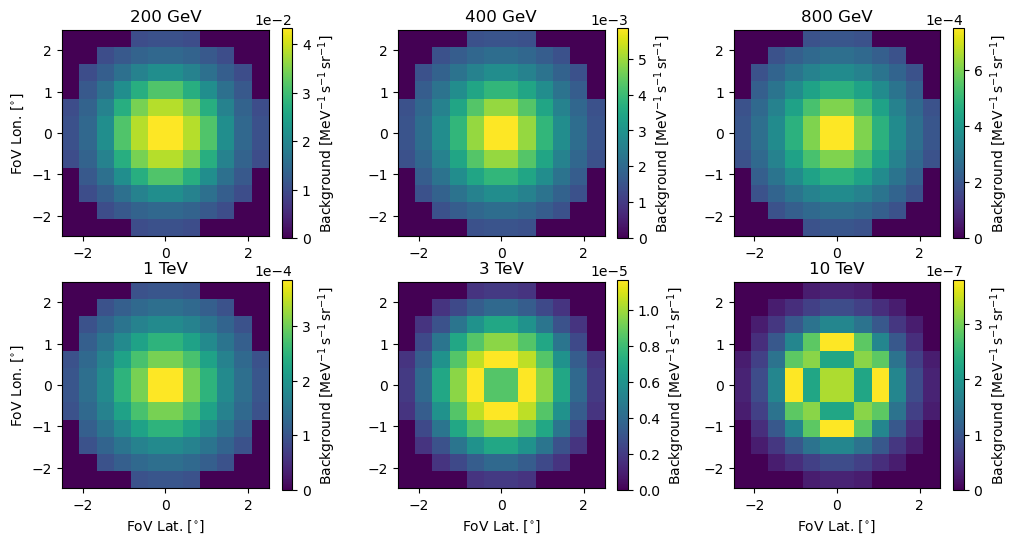

In [9]:
acceptance_model[obs_id].plot_at_energy(
    ["200 GeV", "400 GeV", "800 GeV", "1 TeV", "3 TeV", "10 TeV"])

# Save the acceptance model and store it as background in the data store

In [25]:
# Reload the unmodified data store for safety 
# If it has been modified and already contain a row with a background file, the row cannot be overwritten
data_store = DataStore.from_dir(f"{PATH_DATA}")

# For each observation get the acceptance map, save it and add the saved file path to the data store as a background map
for obs_id in obs_ids:
    hdu_acceptance = acceptance_model[obs_id].to_table_hdu()
    hdu_acceptance.writeto(f'{acceptance_files_dir}/acceptance_'+str(obs_id)+'.fits', overwrite=True)
    data_store.hdu_table.add_row({'OBS_ID': obs_id, 
                                 'HDU_TYPE': 'bkg',
                                 "HDU_CLASS": f"bkg_{bkg_dim}d",
                                 "FILE_DIR": acceptance_files_dir,
                                 "FILE_NAME": 'acceptance_'+str(obs_id)+'.fits',
                                 "HDU_NAME": "BACKGROUND",
                                 "SIZE": hdu_acceptance.size})

# Save the new data store
data_store.hdu_table.write(f"{acceptance_files_dir}/hdu-index.fits.gz",overwrite=True) 
data_store.obs_table.write(f"{acceptance_files_dir}/obs-index.fits.gz",overwrite=True) 

# Get the observations, now with the background
obs_collection = data_store.get_observations(obs_ids,required_irf=['aeff', 'edisp', 'bkg'])
print(data_store)

# Check the saved data store contain the background files
data_store_with_bkg = DataStore.from_dir(f"{acceptance_files_dir}")
data_store_with_bkg.hdu_table

INFO:gammapy.data.data_store:Observations selected: 24 out of 24.


Data store:
HDU index table:
BASE_DIR: /fefs/aswg/workspace/analysis-school-2024/DL3/Crab_Dec_2023
Rows: 168
OBS_ID: 15996 -- 16183
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'pointing', 'rad_max']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'pointing', 'rad_max_2d']


Observation table:
Observatory name: 'N/A'
Number of observations: 24



OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME,SIZE
int64,bytes8,bytes10,bytes17,bytes23,bytes17,int64
15996,events,events,.,dl3_LST-1.Run15996.fits,EVENTS,152035200
15996,gti,gti,.,dl3_LST-1.Run15996.fits,GTI,152035200
15996,pointing,pointing,.,dl3_LST-1.Run15996.fits,POINTING,152035200
15996,aeff,aeff_2d,.,dl3_LST-1.Run15996.fits,EFFECTIVE AREA,152035200
15996,edisp,edisp_2d,.,dl3_LST-1.Run15996.fits,ENERGY DISPERSION,152035200
15996,rad_max,rad_max_2d,.,dl3_LST-1.Run15996.fits,RAD_MAX,152035200
15997,events,events,.,dl3_LST-1.Run15997.fits,EVENTS,154509120
15997,gti,gti,.,dl3_LST-1.Run15997.fits,GTI,154509120
15997,pointing,pointing,.,dl3_LST-1.Run15997.fits,POINTING,154509120


# Create significance map

We now use the background model in our DL3 to create a skymap using the ring background method.
See https://docs.gammapy.org/dev/tutorials/analysis-2d/ring_background.html

__Declare the map geometry__

>* Declare the non-spatial axes
>* Declare the geometry

In [11]:
# Declare the non-spatial axes 
emin_map,emax_map = (e_min , e_max)
unit_map="TeV"
nbin_energy_map = 10

energy_axis = MapAxis.from_energy_bounds(
    emin_map, emax_map, nbin=nbin_energy_map, per_decade=True, unit=unit_map, name="energy"
)

# Reduced IRFs are defined in true energy (i.e. not measured energy). 
# The bounds need to take into account the energy dispersion. 
edisp_frac = 0.3
emin_map_true,emax_map_true = ((1-edisp_frac)*emin_map , (1+edisp_frac)*emax_map)
nbin_energy_map_true = 20

energy_axis_true = MapAxis.from_energy_bounds(
    emin_map_true, emax_map_true, nbin=nbin_energy_map_true, per_decade=True, unit=unit_map, name="energy_true"
)

print(f"Measured energy axis bounds: {emin_map:.1f} - {emax_map:.1f}")
print(f"True energy axis bounds: {emin_map_true:.1f} - {emax_map_true:.1f}")

# Create the map geometry with the additional axes
geom = WcsGeom.create(
    skydir=(source_pos.ra.degree,source_pos.dec.degree),
    binsz=0.02,
    width=(size_fov.value, size_fov.value),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

Measured energy axis bounds: 0.2 TeV - 10.0 TeV
True energy axis bounds: 0.1 TeV - 13.0 TeV


__Create the map and exclusion mask__

>* Create the energy-integrated image from the geometry
>* Make the exclusion mask

CrabNebula position:  <SkyCoord (ICRS): (ra, dec) in deg
    (83.6287, 22.0147)>
Exclusion region radius:  0.35 deg
Exclusion region(s):  [<CircleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (83.6287, 22.0147)>, radius=0.35 deg)>, <CircleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (84.4125, 21.1425)>, radius=0.35 deg)>]


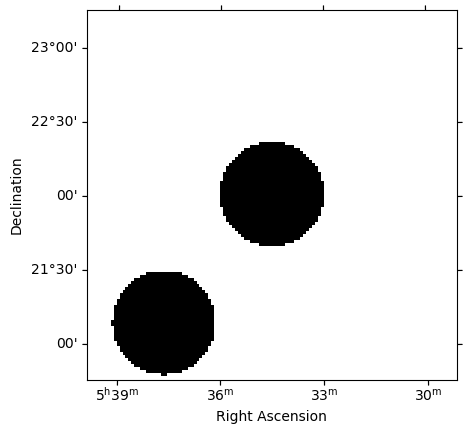

In [12]:
exclusion_radius_map = 1.*exclusion_radius
source_region_map = CircleSkyRegion(center=source_pos, radius=exclusion_radius_map)
zeta_region_map = CircleSkyRegion(center=SkyCoord(ra=84.4125*u.deg, dec=21.1425*u.deg), radius=exclusion_radius)

exclude_regions_map = [source_region_map,zeta_region_map]

print(f"{source} position: ",source_pos)
print("Exclusion region radius: ",exclusion_radius_map)
print("Exclusion region(s): ",exclude_regions_map)

# Get the energy-integrated image
geom_image = geom.to_image().to_cube([energy_axis.squash()])

# Make the exclusion mask
exclusion_mask = geom_image.region_mask(exclude_regions_map, inside=False)
exclusion_mask.plot()
plt.show()

__Create a dataset with all the observation datasets, unstacked__

The offset max parameter is used to determine the spatial range for the maps and the background calculations. 

It is a cut on the offset calculated from the pointing position.

In [13]:
# An error message about ambiguous axes order appear when the shape of the background model is (N,N) in 2D, (N,N,N) in 3D

offset_max = 2.5 * u.deg
base_map_dataset = MapDataset.create(geom=geom)
unstacked_datasets = Datasets()
maker = MapDatasetMaker(selection=["counts", "background"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)

for obs in obs_collection:
    dataset = maker.run(base_map_dataset.copy(), obs)
    dataset = maker_safe_mask.run(dataset, obs)
    unstacked_datasets.append(dataset)

ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammapy.irf.background:Ambiguous axes order in Background fits files!
ERROR:gammap

__Apply the ring background model method to each dataset__

> * Declare the ring background maker
>   
> `r_in` defines the distance to the inner edge of the ring
> 
> `width` defines the thickness of the ring
> 
> At each position the background is estimated using a ring covering the distance between `r_in` and `r_in`+`width`
> 
> Sections of the ring in an exclusion region are not used

In [14]:
print("Exclusion region radius: ",exclusion_radius_map)

int_off = 0.1 * u.deg
internal_ring_radius = exclusion_radius_map + int_off
width_ring=0.3 * u.deg

ring_bkg_maker = RingBackgroundMaker(r_in=internal_ring_radius,
                                         width=width_ring,
                                         exclusion_mask=exclusion_mask)

Exclusion region radius:  0.35 deg


>* Create a background map using the ring background method for each observation dataset
>* Stack the datasets and create a MapDatasetOnOff stacked dataset

In [15]:
stacked_on_off = MapDatasetOnOff.create(
    geom=geom_image, energy_axis_true=energy_axis_true, name="stacked"
)

unstacked_datasets_local = unstacked_datasets.copy()
for dataset in unstacked_datasets_local:
    # Ring extracting makes sense only for 2D analysis
    dataset_on_off = ring_bkg_maker.run(dataset.to_image())
    stacked_on_off.stack(dataset_on_off)

print(stacked_on_off)

MapDatasetOnOff
---------------

  Name                            : stacked 

  Total counts                    : 177744 
  Total background counts         : 166080.73
  Total excess counts             : 11663.27

  Predicted counts                : 166085.58
  Predicted background counts     : 166085.58
  Predicted excess counts         : nan

  Exposure min                    : 0.00e+00 m2 s
  Exposure max                    : 0.00e+00 m2 s

  Number of total bins            : 15625 
  Number of fit bins              : 15625 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 33877.49

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 296424896 
  Acceptance                      : 15625 
  Acceptance off                  : 27278228 



__Create the significance and excess maps__

>* Get the estimator
>* Get the maps from the estimator

The correlation radius is the radius of the area used to integrate the ON counts to obtain the excess and the significance.

OFF counts are integrated in the same region if `correlate_off=True`. But this should not be used in the ring background analysis.

In [16]:
# Get the estimator
correlation_radius=0.08 * u.deg
estimator = ExcessMapEstimator(correlation_radius, correlate_off=False)
lima_maps = estimator.run(stacked_on_off)

# Get the maps
significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["npred_excess"]

__Plot the maps__

>* Background and counts maps

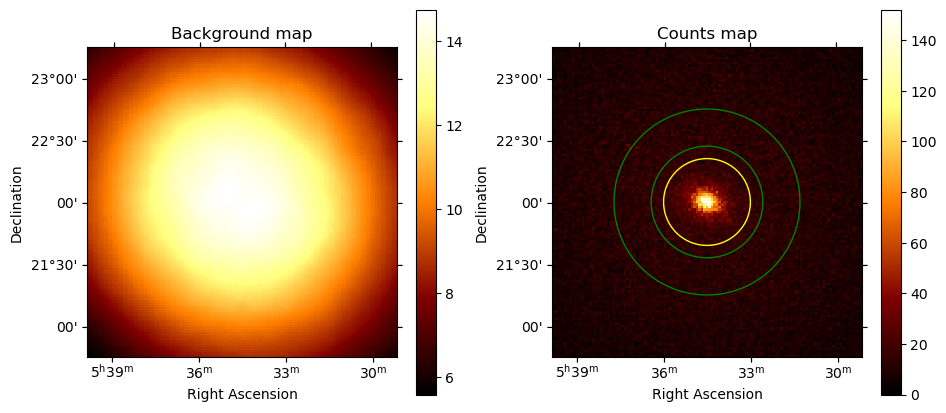

In [17]:
fig, (ax1, ax2) = plt.subplots(
    figsize=(11, 5), subplot_kw={"projection": lima_maps.geom.wcs}, ncols=2
)

ax1.set_title("Background map")
stacked_on_off.background.sum_over_axes().plot(ax=ax1, add_cbar=True, stretch="linear")

ax2.set_title("Counts map")
stacked_on_off.counts.sum_over_axes().plot(ax=ax2, add_cbar=True, stretch="linear")

r1 = SphericalCircle((source_pos.ra ,source_pos.dec), exclusion_radius_map,
                     edgecolor='yellow', facecolor='none',
                     transform=ax2.get_transform('icrs'))
r2 = SphericalCircle((source_pos.ra ,source_pos.dec), internal_ring_radius,
                     edgecolor='green', facecolor='none',
                     transform=ax2.get_transform('icrs'))
r3 = SphericalCircle((source_pos.ra ,source_pos.dec), internal_ring_radius+width_ring,
                     edgecolor='green', facecolor='none',
                     transform=ax2.get_transform('icrs'))
ax2.add_patch(r2)
ax2.add_patch(r1)
ax2.add_patch(r3)

>* Significance and excess maps

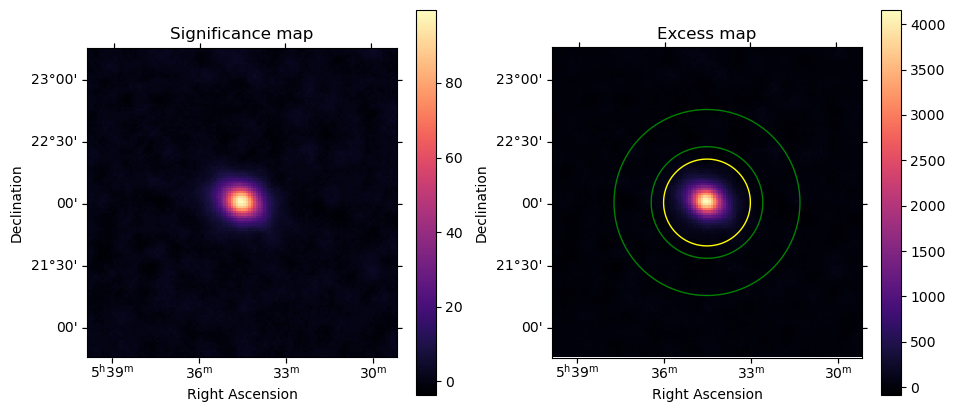

In [18]:
fig, (ax1, ax2) = plt.subplots(
    figsize=(11, 5), subplot_kw={"projection": lima_maps.geom.wcs}, ncols=2
)

significance_map_off = significance_map * exclusion_mask

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True, stretch="linear", cmap='magma')

ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True, stretch="linear", cmap='magma')

source_pos = SkyCoord.from_name(source_name)
r1 = SphericalCircle((source_pos.ra ,source_pos.dec), exclusion_radius_map,
                     edgecolor='yellow', facecolor='none',
                     transform=ax2.get_transform('icrs'))
r2 = SphericalCircle((source_pos.ra ,source_pos.dec), internal_ring_radius,
                     edgecolor='green', facecolor='none',
                     transform=ax2.get_transform('icrs'))
r3 = SphericalCircle((source_pos.ra ,source_pos.dec), internal_ring_radius+width_ring,
                     edgecolor='green', facecolor='none',
                     transform=ax2.get_transform('icrs'))
ax2.add_patch(r2)
ax2.add_patch(r1)
ax2.add_patch(r3)

plt.show()

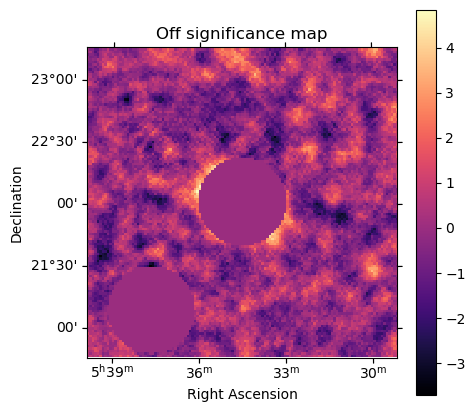

In [19]:
fig, (ax1) = plt.subplots(
    figsize=(5, 5), subplot_kw={"projection": lima_maps.geom.wcs}, ncols=1
)

significance_map_off = significance_map * exclusion_mask

ax1.set_title("Off significance map")
significance_map_off.plot(ax=ax1, add_cbar=True, stretch="linear", cmap='magma')

plt.show()

# Plot the background residuals

>* Get the background significane in the exclusion region

In [20]:
significance_background = lima_maps["sqrt_ts"].data[
np.logical_and(np.isfinite(lima_maps["sqrt_ts"].data), exclusion_mask.data)]
mu, std = norm.fit(significance_background)
print(f"The background significance should be a normal distribution centered on 0 and of standard deviation 1. We have:\n mu = {mu}, std = {std}")

The background significance should be a normal distribution centered on 0 and of standard deviation 1. We have:
 mu = -0.009128486683916604, std = 1.0006583863019063


>* Create a 2D mask for the images
>* Plot the significances
>* Fit the off significance with a Gaussian to get the mean and standard deviation

mu =  -0.009128486683916604  std=  1.0006583863019063


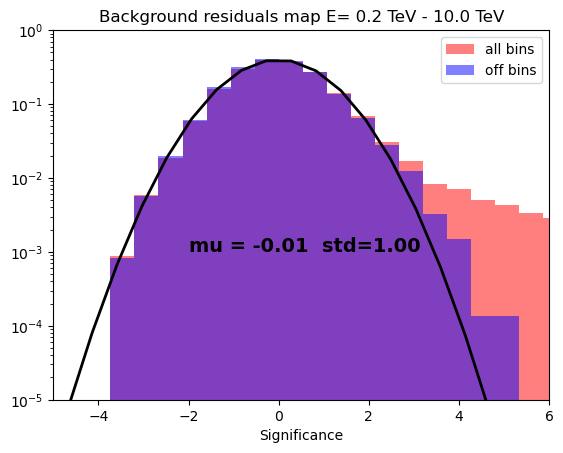

In [21]:
# create a 2D mask for the images
significance_map_off = significance_map * exclusion_mask
significance_all = significance_map.data[np.isfinite(significance_map.data)]
significance_off = significance_map.data[np.logical_and(np.isfinite(significance_map.data), 
                                                        exclusion_mask.data)]

# Plot the significances
fig, ax = plt.subplots()

ax.hist(
    significance_all,
    range=(-8,8),
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=30,
)

ax.hist(
    significance_off,
    range=(-8,8),
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 30)
p = norm.pdf(x, mu, std)
ax.plot(x, p, lw=2, color="black")
p2 = norm.pdf(x, 0, 1)
#ax.plot(x, p2, lw=2, color="green")
ax.set_title(f"Background residuals map E= {emin_map:.1f} - {emax_map:.1f}")
ax.text(-2.,0.001, f'mu = {mu:3.2f}  std={std:3.2f}',fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlabel("Significance")
ax.set_yscale("log")
ax.set_ylim(1e-5, 1)
ax.set_xlim(-5,6.)
#xmin, xmax = np.min(significance_off), np.max(significance_off)
#ax.set_xlim(xmin, xmax)
print("mu = ", mu," std= ",std )

__Use the FoV background method__

>* Declare the FoV background maker
>* Apply the FoV background method to each dataset
>* Stack the datasets now containing FoV background
>* Create the estimator from the stacked dataset

In [22]:
datasets_with_FoV_background = Datasets()
maker_FoV_background = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask)

unstacked_datasets_local = unstacked_datasets.copy()
for dataset in unstacked_datasets_local:
        dataset.counts.data[~dataset.mask_safe] = 0
        dataset = maker_FoV_background.run(dataset)
        datasets_with_FoV_background.append(dataset)
        
estimator = ExcessMapEstimator(correlation_radius)
lima_maps = estimator.run(datasets_with_FoV_background.stack_reduce())

>* Plot the maps

mu =  -0.00016445534  std=  1.0090283


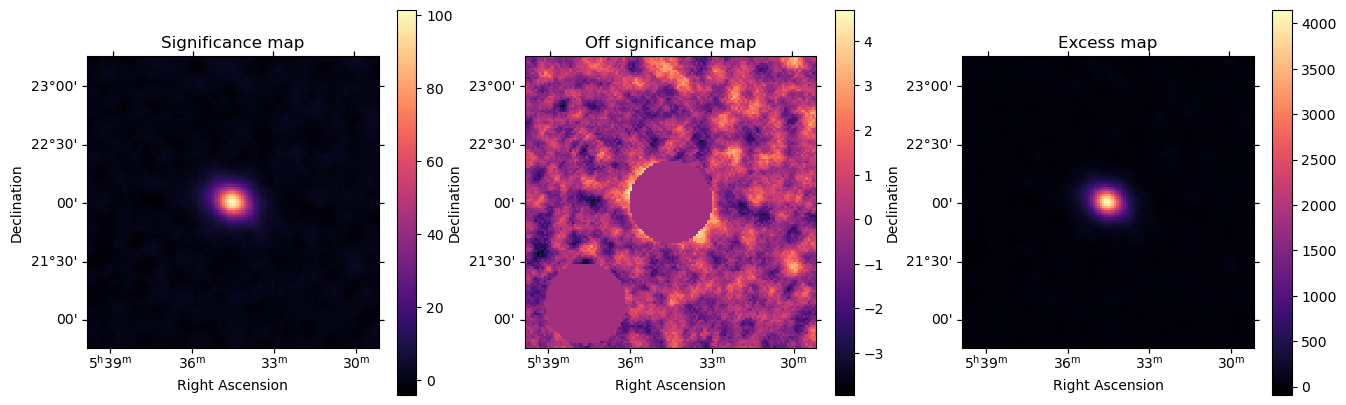

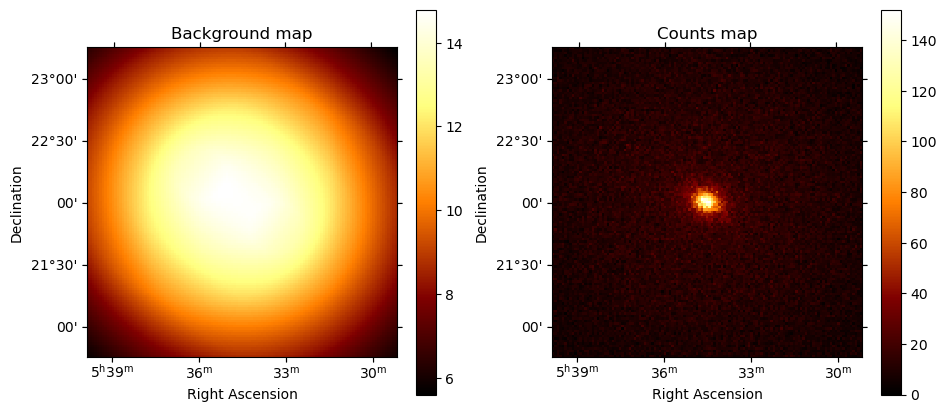

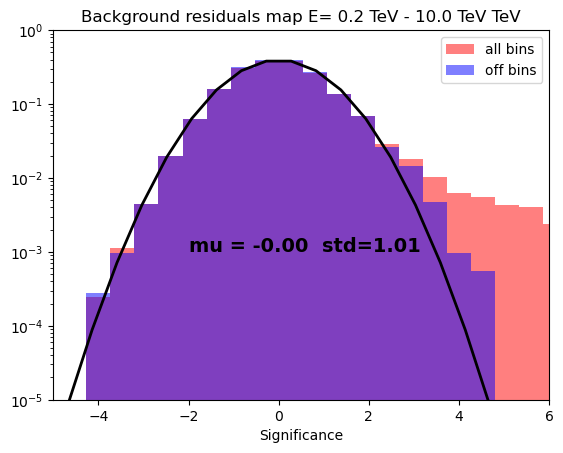

In [23]:
# Get the maps
significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["npred_excess"]

# Significance and excess

fig, (ax1, ax2, ax3) = plt.subplots(
    figsize=(16, 5), subplot_kw={"projection": lima_maps.geom.wcs}, ncols=3
)

significance_map_off = significance_map * exclusion_mask

ax1.set_title("Significance map")
#significance_map.plot(ax=ax1, add_cbar=True, stretch="linear")
significance_map.plot(ax=ax1, add_cbar=True, stretch="linear", cmap='magma')

ax2.set_title("Off significance map")
#significance_map.plot(ax=ax1, add_cbar=True, stretch="linear")
significance_map_off.plot(ax=ax2, add_cbar=True, stretch="linear", cmap='magma')

ax3.set_title("Excess map")
excess_map.plot(ax=ax3, add_cbar=True, stretch="linear", cmap='magma')

# Background and counts

fig, (ax1, ax2) = plt.subplots(
    figsize=(11, 5), subplot_kw={"projection": lima_maps.geom.wcs}, ncols=2
)

ax1.set_title("Background map")
datasets_with_FoV_background.stack_reduce().background.sum_over_axes().plot(ax=ax1, add_cbar=True, stretch="linear")

ax2.set_title("Counts map")
datasets_with_FoV_background.stack_reduce().counts.sum_over_axes().plot(ax=ax2, add_cbar=True, stretch="linear")


# Residuals

significance_map_off = significance_map * exclusion_mask
significance_all = significance_map.data[np.isfinite(significance_map.data)]
significance_off = significance_map.data[np.logical_and(np.isfinite(significance_map.data), 
                                                        exclusion_mask.data)]

fig, ax = plt.subplots()

ax.hist(
    significance_all,
    range=(-8,8),
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=30,
)

ax.hist(
    significance_off,
    range=(-8,8),
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=30,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 30)
p = norm.pdf(x, mu, std)
ax.plot(x, p, lw=2, color="black")
p2 = norm.pdf(x, 0, 1)
#ax.plot(x, p2, lw=2, color="green")
ax.set_title(f"Background residuals map E= {emin_map:.1f} - {emax_map:.1f} {unit_map}")
ax.text(-2.,0.001, f'mu = {mu:3.2f}  std={std:3.2f}',fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlabel("Significance")
ax.set_yscale("log")
ax.set_ylim(1e-5, 1)
ax.set_xlim(-5,6.)
#xmin, xmax = np.min(significance_off), np.max(significance_off)
#ax.set_xlim(xmin, xmax)
print("mu = ", mu," std= ",std )

# Exercise 1: Another point source with BLLac

Use this notebook to create the acceptance and background models with the BLLac data.

__path:__ /fefs/aswg/workspace/analysis-school-2024/DL3/BLLac_20221020

Some source-specific details:
>* The source position can be obtained by name with "BL Lac"
>* Use a single exclusion region

Some dataset-specific details:
>* Set zenith_bin=False due to the lack of statistics with only 4 observations

# Exercise 2: Extended source with RXJ 1713.7-3946

Use this notebook to create the acceptance and background models with the RXJ 1713.7-3946 data from gammapy-extra datasets.

__path:__ ./gammapy-extra/datasets/hess-dl3-dr1

Some source-specific details:
>* The source position obtained from name is not correct, it is better to use a custom source position in galactic frame: (lon,lat) = (347.3°, -0.5°)
>* Use a single exclusion region
>* Use 100 GeV - 10 TeV as energy bounds
>* Use int_off=0.5°

Some HESS-specific details: 
>* The FoV size is 3°
>* DL3 HESS data already have a background model. You will need to remove it from the data store with this command: data_store.hdu_table.remove_rows(data_store.hdu_table['HDU_TYPE']=='bkg')
>* The angular resolution is better, you can use a smaller correlation radius: 0.04°